In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
import zipfile
import os

dataset_path = "/content/drive/MyDrive/Colab Notebooks/landscape Images.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
from numpy import zeros, ones
import random
from random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, Activation, Concatenate, Dropout, BatchNormalization ,LeakyReLU
)
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from numpy.random import randint
from tensorflow import keras
from keras.losses import BinaryCrossentropy


In [ ]:
def define_discriminator(input_shape):
    init=RandomNormal(stddev=0.02)
    input_src_image=Input(shape=image_shape)
    input_target_images=Input(shape=image_shape)

    merged=Concatenate()([input_src_image,input_target_images])

    d=Conv2D(64,(4,4),padding='same',kernel_initializer=init)(merged)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(128,(4,4),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(256,(4,4),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)
    d=Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    patch_output=Activation('sigmoid')(d)

    model=Model([input_src_image,input_target_images],patch_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
def encoder(layer_input,n_filters,bathnorm=True):
    init=RandomNormal(stddev=0.02)
    g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_input)
    if bathnorm:
        g=BatchNormalization()(g, training=True)
    g=LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
def decoder(layer_input,skip_input,n_filters,dropout=True):
    init=RandomNormal(stddev=0.02)
    g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_input)
    g=BatchNormalization()(g, training=True)
    if dropout:
        g=Dropout(0.5)(g, training=True)
    g=Concatenate()([g, skip_input])
    g=Activation('relu')(g)
    return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
    init=RandomNormal(stddev=0.02)
    input_image=Input(shape=image_shape)

    e1=encoder(input_image,64,bathnorm=False)
    e2=encoder(e1,128)
    e3=encoder(e2,256)
    e4=encoder(e3,512)
    e5=encoder(e4,512)
    e6=encoder(e5,512)
    e7=encoder(e6,512)

    base=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    base=Activation('relu')(base)

    d1=decoder(base,e7,512)
    d2=decoder(d1,e6,512)
    d3=decoder(d2,e5,512)
    d4=decoder(d3,e4,512,dropout=False)
    d5=decoder(d4,e3,256,dropout=False)
    d6=decoder(d5,e2,128,dropout=False)
    d7=decoder(d6,e1,64,dropout=False)

    g=Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    output_image=Activation('tanh')(g)

    model=Model(input_image,output_image)
    return model

In [ ]:
def gan(g_model,d_model,image_shape):
    for layer in d_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable=False

    input_src=Input(shape=image_shape)
    gen_out=g_model(input_src)
    dis_out=d_model([input_src,gen_out])
    model=Model(input_src,[dis_out,gen_out])
    opt=Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss=['binary_crossentropy','mae'],optimizer=opt)
    return model

In [ ]:
def generate_real_sample(dataset,n_samples,patch_shape):
    trainA,trainB=dataset
    ix=np.random.randint(0,trainA.shape[0],n_samples)
    x1,x2=trainA[ix],trainB[ix]
    y=ones((n_samples,patch_shape,patch_shape,1))
    return [x1,x2],y

In [ ]:
def generate_fake_sample(g_model,samples,patch_shape):
    x=g_model.predict(samples)
    y=zeros((len(x),patch_shape,patch_shape,1))
    return x,y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
import os
from tensorflow.keras.optimizers import Adam

def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # Create a directory to save weights if it doesn't exist
    os.makedirs('weights', exist_ok=True)

    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    batch_per_epo = int(len(trainA) / n_batch)
    n_steps = batch_per_epo * n_epochs

    # Initialize Adam optimizer with custom learning rate and beta_1
    adam_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    # Compile models with Adam optimizer
    d_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, loss_weights=[0.5])
    g_model.compile(loss=['binary_crossentropy', 'mae'], loss_weights=[1, 100], optimizer=adam_optimizer)

    for step in range(n_steps):
        # Generate real and fake samples
        [x_realA, x_realB], y_real = generate_real_sample(dataset, n_batch, n_patch)
        x_fakeB, y_fake = generate_fake_sample(g_model, x_realA, n_patch)

        # Update discriminator model
        d_loss1 = d_model.train_on_batch([x_realA, x_realB], y_real)
        d_loss2 = d_model.train_on_batch([x_realA, x_fakeB], y_fake)

        # Update generator model
        g_loss, _, _ = gan_model.train_on_batch(x_realA, [y_real, x_realB])

        # Print performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (step + 1, d_loss1, d_loss2, g_loss))

        # Periodically summarize performance
        if (step + 1) % (batch_per_epo * 10) == 0:
            summarize_performance(step, g_model, dataset)


In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [ ]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

# Function to sort filenames alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Defining image size
SIZE = 256

# Initialize lists for source and target images
src_images = []
tar_images = []

# Path to images
path = '/content/dataset/landscape Images'

# Alphanumerically sorted list of filenames
color_files = sorted_alphanumeric(os.listdir(f"{path}/color"))[:2000]
gray_files = sorted_alphanumeric(os.listdir(f"{path}/gray"))[:2000]

# Load and process the first 2000 images
for color_file, gray_file in tqdm(zip(color_files, gray_files), total=2000):
    # Load and process color image
    color_img = cv2.imread(f"{path}/color/{color_file}", 1)
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    color_img = cv2.resize(color_img, (SIZE, SIZE))

    # Load and process gray image
    gray_img = cv2.imread(f"{path}/gray/{gray_file}", 1)
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.resize(gray_img, (SIZE, SIZE))

    # Concatenate images along the width (axis 1) to match the second code's format
    combined_img = np.concatenate((gray_img, color_img), axis=1)

    # Split into source (gray) and target (color)
    src_img, tar_img = combined_img[:, :SIZE], combined_img[:, SIZE:]
    src_images.append(src_img)
    tar_images.append(tar_img)

# Convert to numpy arrays
src_images = np.asarray(src_images)
tar_images = np.asarray(tar_images)

print('Loaded: ', src_images.shape, tar_images.shape)


100%|██████████| 2000/2000 [00:02<00:00, 845.37it/s]


Loaded:  (2000, 256, 256, 3) (2000, 256, 256, 3)


In [ ]:
# import os
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import numpy as np
# from PIL import Image

# def is_valid_image(file_path):
#     """Check if a file is a valid image."""
#     try:
#         with Image.open(file_path) as img:
#             img.verify()  # Verify image integrity
#         return True
#     except Exception:
#         return False

# def load_images(path, size=(256, 512)):
#     src_list, tar_list = list(), list()

#     # Walk through all subdirectories
#     for root, dirs, files in os.walk(path):
#         print(f"Checking directory: {root}")  # Debug: Show directories being processed
#         for filename in files:
#             full_path = os.path.join(root, filename)

#             if is_valid_image(full_path):  # Ensure it's a valid image
#                 try:
#                     print(f"Loading image: {full_path}")  # Debug: Show images being loaded
#                     pixels = load_img(full_path, target_size=size)
#                     pixels = img_to_array(pixels)

#                     # Split into satellite (gray) and map (color)
#                     sat_img, map_img = pixels[:, :256], pixels[:, 256:]
#                     src_list.append(sat_img)
#                     tar_list.append(map_img)
#                 except Exception as e:
#                     print(f"Skipping {filename} due to error: {e}")  # Log errors but continue
#             else:
#                 print(f"Skipping invalid image: {filename}")  # Log skipped files

#     return [np.asarray(src_list), np.asarray(tar_list)]

# # Dataset path
# path = '/content/dataset/landscape Images'
# [src_images, tar_images] = load_images(path)
# print('Loaded:', src_images.shape, tar_images.shape)


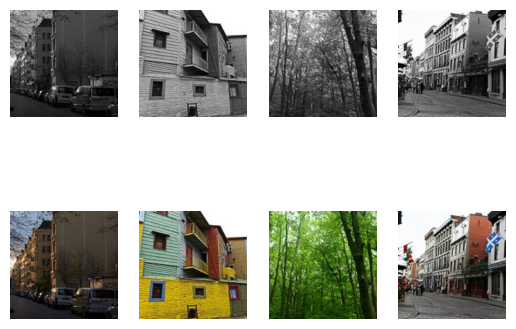

In [ ]:
n_samples = 4
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(tar_images[i].astype('uint8'))
plt.show()


In [ ]:
image_shape=src_images.shape[1:]
d_model=define_discriminator(image_shape)
g_model=define_generator(image_shape)
data=[src_images,tar_images]

def preprocess_data(data):
    x1,x2=data[0],data[1]
    x1=(x1-127.5)/127.5
    x2=(x2-127.5)/127.5
    return [x1,x2]

dataset=preprocess_data(data)

from datetime import datetime
start1 = datetime.now()

gan_model = gan(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1)

stop1 = datetime.now()

execution_time = stop1-start1
print("Execution time is: ", execution_time)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
>4314, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>4315, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>4316, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>4317, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>4318, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>4319, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>4320, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>4321, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>4322, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>4323, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>4324, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>4325, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>4326, d1[0.451] d2[0.451] g[0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [19]:
g_model.save("test_gan_1.h5")

In [ ]:
# data=[src_images,tar_images]

# def preprocess_data(data):
#     x1,x2=data[0],data[1]
#     x1=(x1-127.5)/127.5
#     x2=(x2-127.5)/127.5
#     return [x1,x2]

# dataset=preprocess_data(data)

In [ ]:
# from keras.models import load_model
# from numpy.random import randint
# from keras.losses import MeanAbsoluteError
# from matplotlib import pyplot

# model = load_model('./test_gan_1.h5', custom_objects={'mae': MeanAbsoluteError()})


# # plot source, generated and target images
# def plot_images(src_img, gen_img, tar_img):
# 	images = np.vstack((src_img, gen_img, tar_img))
# 	# scale from [-1,1] to [0,1]
# 	images = (images + 1) / 2.0
# 	titles = ['Source', 'Generated', 'Expected']
# 	# plot images row by row
# 	for i in range(len(images)):
# 		# define subplot
# 		pyplot.subplot(1, 3, 1 + i)
# 		# turn off axis
# 		pyplot.axis('off')
# 		# plot raw pixel data
# 		pyplot.imshow(images[i])
# 		# show title
# 		pyplot.title(titles[i])
# 	pyplot.show()



# [X1, X2] = dataset
# # select random example
# for i in range(20):
#     ix = randint(0, len(X1), 1)
#     src_image, tar_image = X1[ix], X2[ix]
# # generate image from source
#     gen_image = model.predict(src_image)
# # plot all three images
#     plot_images(src_image, gen_image, tar_image)


In [ ]:
# # Save the entire models
# g_model.save('./gan_weights/generator_model.h5')
# d_model.save('./gan_weights/discriminator_model.h5')
# gan_model.save('./gan_weights/gan_model.h5')